In [1]:
s_ticker = "C"

In [2]:
# all my ticker data is in data folder under <s_ticker>_stock_data.csv naming convention
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def get_data(ticker):
    data_path = os.path.join("data", f"{ticker}_stock_data.csv")
    if not os.path.exists(data_path):
        print(f"Data file for {ticker} not found.")
        sys.exit(1)
    return pd.read_csv(data_path, index_col=0)

In [3]:
df = get_data(s_ticker)
print(df.head(5))


                                Open       High        Low      Close  \
Date                                                                    
2023-08-02 00:00:00-04:00  43.029051  43.270060  42.593387  42.927090   
2023-08-03 00:00:00-04:00  42.611926  43.075402  42.370917  42.834393   
2023-08-04 00:00:00-04:00  42.881273  43.781469  42.721865  42.862518   
2023-08-07 00:00:00-04:00  43.087568  43.359503  42.787502  42.975044   
2023-08-08 00:00:00-04:00  42.215504  42.412422  41.390323  42.346783   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-08-02 00:00:00-04:00  13101100       0.00           0.0  
2023-08-03 00:00:00-04:00  13467100       0.00           0.0  
2023-08-04 00:00:00-04:00  18329500       0.53           0.0  
2023-08-07 00:00:00-04:00  16972000       0.00           0.0  
2023-08-08 00:00:00-04:00  18524500       0.00           0.0  


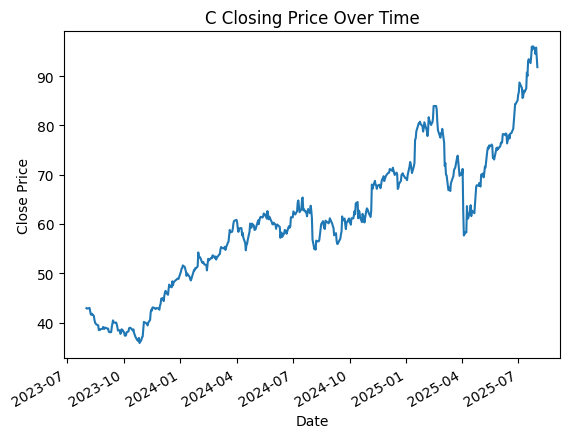

In [4]:
# plot the close price with dates on x-axis

df.index = pd.to_datetime(df.index)
df['Close'].plot()
plt.title(f"{s_ticker} Closing Price Over Time")
plt.ylabel("Close Price")
plt.show()


In [6]:
# what is average rate increase for each month
df['Close_diff'] = df['Close'].diff()
df.groupby('Month')['Close_diff'].mean().plot(kind='bar')
plt.title("Average Monthly Close Price Change")
plt.ylabel("Average Daily Price Change")
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(12), month_names)
plt.show()

KeyError: 'Month'

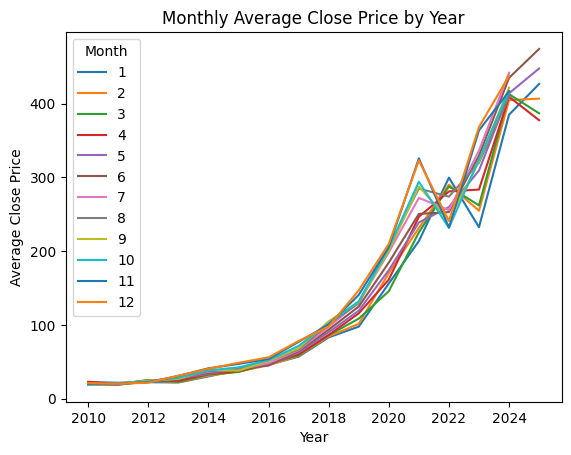

In [64]:
# Show all close prices for each year for each month color coded
df.groupby(['Year','Month'])['Close'].mean().unstack().plot()
plt.title("Monthly Average Close Price by Year")
plt.ylabel("Average Close Price")
plt.show()


In [65]:
%pip install plotly
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [66]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL, MSTL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [67]:
print(df['Close'])

2025-06-24    490.1100
2025-06-23    486.0000
2025-06-20    477.4000
2025-06-18    480.2400
2025-06-17    478.0400
                ...   
2010-01-11     22.7015
2010-01-08     22.9940
2010-01-07     22.8365
2010-01-06     23.0765
2010-01-05     23.2189
Name: Close, Length: 3891, dtype: float64


In [68]:
# Set start and end dates from the file's date range
import yfinance as yf
start = str(df.index.min().date())
end = str(df.index.max().date())
train_start = start
train_end = '2023-12-31'
test_start = train_end
test_end = end
period = 12 # for STL decomposition

In [17]:
# create train and test dataframes
train_df = df[(df.index >= train_start) & (df.index <= train_end)]
test_df = df[(df.index >= test_start) & (df.index <= test_end)]


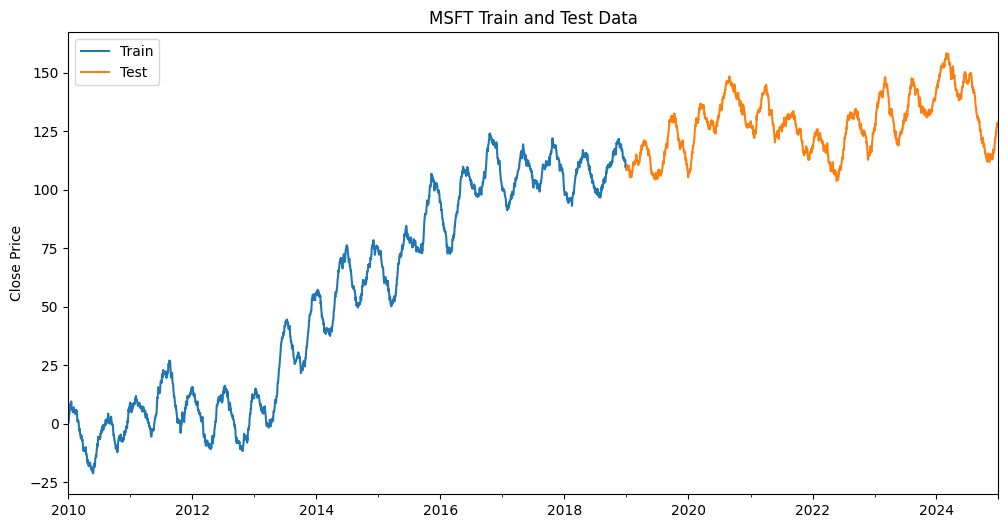

In [69]:
# plot the train and test dataframes
train_df['Close'].plot(label='Train', figsize=(12, 6))
test_df['Close'].plot(label='Test')
plt.title(f"{s_ticker} Train and Test Data")
plt.ylabel("Close Price")
plt.legend()
plt.show()

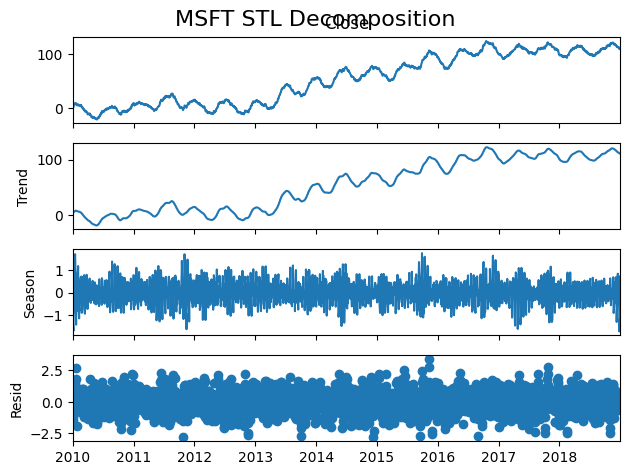

In [70]:
# lets do stl decomposition on the train data
stl = STL(train_df['Close'], period=period)
stl_result = stl.fit()

# plot the STL decomposition
stl_result.plot()
plt.suptitle(f"{s_ticker} STL Decomposition", fontsize=16)
plt.show()



<Figure size 1200x800 with 0 Axes>

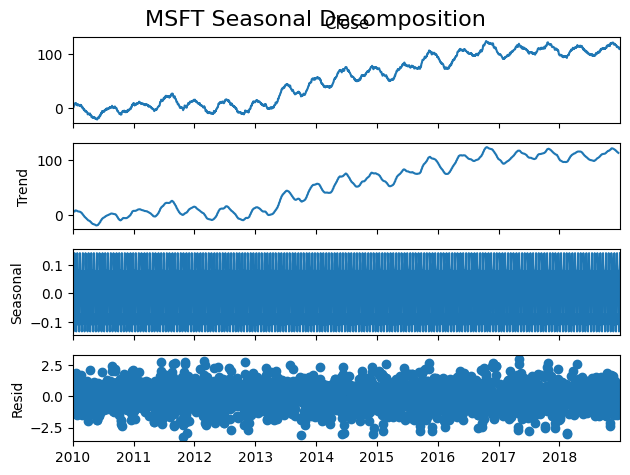

In [71]:
# lets do seasonal decomposition using statsmodels
results = seasonal_decompose(train_df['Close'], model='additive', period=period)


# plot the seasonal decomposition
plt.figure(figsize=(12, 8))
results.plot()
plt.suptitle(f"{s_ticker} Seasonal Decomposition", fontsize=16)
plt.show()

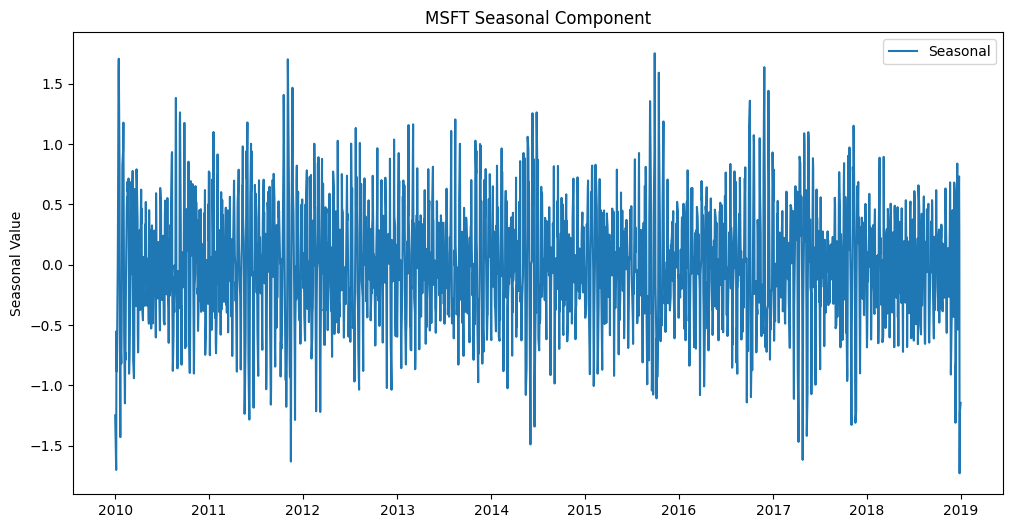

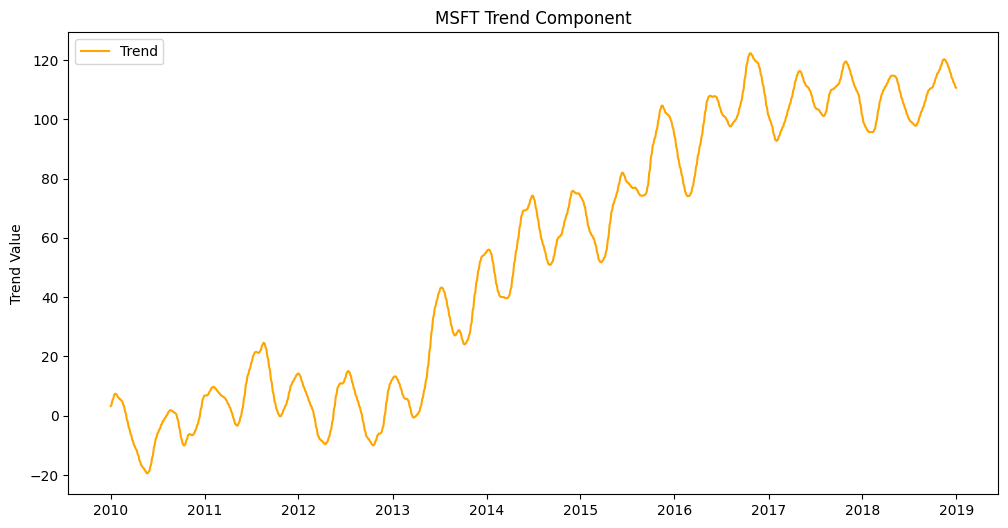

In [72]:
# seasonal is too noisy, lets use STL decomposition
season_and_trend = stl_result.seasonal + stl_result.trend

# lets plot the seasonal and trend components in two separate plots


plt.figure(figsize=(12, 6))
plt.plot(stl_result.seasonal, label='Seasonal')
plt.title(f"{s_ticker} Seasonal Component")
plt.ylabel("Seasonal Value")
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(stl_result.trend, label='Trend', color='orange')
plt.title(f"{s_ticker} Trend Component")
plt.ylabel("Trend Value")
plt.legend()
plt.show()

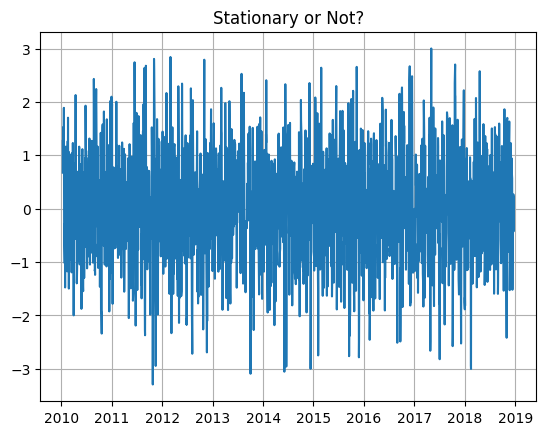

In [73]:
plt.plot(results.resid)
plt.grid()
plt.title('Stationary or Not?');

In [74]:
# Check stationarity of the residuals for each year using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

years = train_df.index.year.unique()
for year in years:
    year_resid = results.resid[train_df.index.year == year].dropna()
    if len(year_resid) > 0:
        adf_result = adfuller(year_resid)
        print(f'Year: {year}')
        print('  ADF Statistic:', adf_result[0])
        print('  p-value:', adf_result[1])
        if adf_result[1] < 0.05:
            print('  The series is likely stationary (reject H0)')
        else:
            print('  The series is likely non-stationary (fail to reject H0)')
        print('-'*40)

Year: 2010
  ADF Statistic: -9.37068682402481
  p-value: 7.391628428418056e-16
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2011
  ADF Statistic: -9.022877358912373
  p-value: 5.7123235064689015e-15
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2012
  ADF Statistic: -9.102783626912675
  p-value: 3.5683052431692004e-15
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2013
  ADF Statistic: -8.195289455245865
  p-value: 7.477874498736242e-13
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2014
  ADF Statistic: -8.754660644245817
  p-value: 2.7762548529250712e-14
  The series is likely stationary (reject H0)
----------------------------------------
Year: 2015
  ADF Statistic: -10.12942821477905
  p-value: 8.99958971142122e-18
  The series is likely stationary (reject H0)
--------------------------------------

In [75]:
# Forecast the entire test data range using STL decomposition and ARIMA with specified order
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# STL requires 'seasonal' to be an odd positive integer >= 3
# Specify ARIMA order for better modeling
print('Train data tail:')
print(train_df['Close'].tail())
stl_forecast = STLForecast(
	train_df['Close'],
	model=ARIMA,
	model_kwargs={"order": (2, 1, 2)},
	period=period,
	seasonal=13
)
stl_forecast_result = stl_forecast.fit()
# forecast for the length of the test set
forecast_steps = len(test_df)
forecast = stl_forecast_result.forecast(steps=forecast_steps)
print('Forecast head:')
print(forecast.head())
print('Forecast tail:')
print(forecast.tail())


Train data tail:
2018-12-25    112.748646
2018-12-26    111.919195
2018-12-27    109.482186
2018-12-28    110.316164
2018-12-31    109.595332
Freq: B, Name: Close, dtype: float64
Forecast head:
2019-01-01    110.251868
2019-01-02    110.247649
2019-01-03    109.959087
2019-01-04    109.343188
2019-01-07    108.825985
Freq: B, dtype: float64
Forecast tail:
2024-12-25    105.136156
2024-12-26    105.018100
2024-12-27    104.644708
2024-12-30    104.286750
2024-12-31    104.989231
Freq: B, dtype: float64


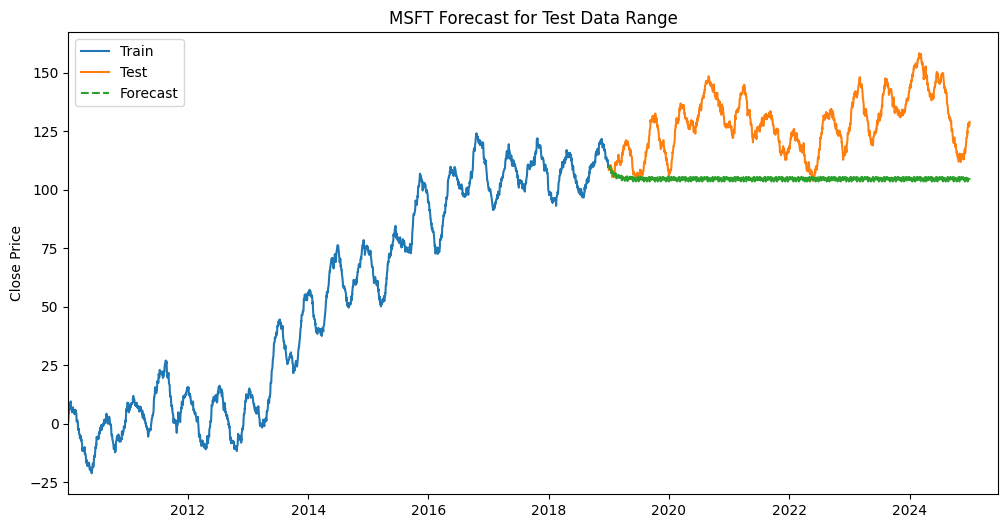

In [77]:
# plot the train, test, and forecast dataframes with x-axis limited to the dataframe date range
plt.figure(figsize=(12, 6))
plt.plot(train_df['Close'], label='Train')
plt.plot(test_df['Close'], label='Test')
forecast.index = test_df.index  # align forecast index with test data
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title(f"{s_ticker} Forecast for Test Data Range")
plt.ylabel("Close Price")
plt.legend()
plt.xlim(df.index.min(), df.index.max())
plt.show()

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# STL and time series libraries
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def enhanced_stl_analysis(df, s_ticker, period=12):
    """
    Enhanced STL analysis with automatic parameter optimization and evaluation
    """
    
    # Ensure datetime index
    df.index = pd.to_datetime(df.index)
    
    # Set up train/test split
    start = str(df.index.min().date())
    end = str(df.index.max().date())
    train_end = '2018-12-31'
    test_start = '2019-01-01'
    
    train_df = df[(df.index <= train_end)]
    test_df = df[(df.index >= test_start)]
    
    print(f"Train period: {train_df.index.min()} to {train_df.index.max()}")
    print(f"Test period: {test_df.index.min()} to {test_df.index.max()}")
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    
    if len(train_df) < 2 * period or len(test_df) == 0:
        print("❌ Insufficient data for STL analysis")
        return None
    
    # 1. STL Decomposition Analysis
    print("\n🔍 STL Decomposition Analysis")
    print("=" * 50)
    
    stl = STL(train_df['Close'], period=period, seasonal=13)
    stl_result = stl.fit()
    
    # Plot STL components
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original
    axes[0].plot(train_df.index, train_df['Close'], 'b-', linewidth=1)
    axes[0].set_title(f'{s_ticker} - Original Close Price')
    axes[0].grid(True, alpha=0.3)
    
    # Trend
    axes[1].plot(train_df.index, stl_result.trend, 'g-', linewidth=2)
    axes[1].set_title('Trend Component')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal
    axes[2].plot(train_df.index, stl_result.seasonal, 'r-', linewidth=1)
    axes[2].set_title('Seasonal Component')
    axes[2].grid(True, alpha=0.3)
    
    # Residual
    axes[3].plot(train_df.index, stl_result.resid, 'purple', linewidth=1)
    axes[3].set_title('Residual Component')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Component Analysis
    trend_strength = max(0, 1 - np.var(stl_result.resid) / np.var(stl_result.trend + stl_result.resid))
    seasonal_strength = max(0, 1 - np.var(stl_result.resid) / np.var(stl_result.seasonal + stl_result.resid))
    
    print(f"📊 Component Strength:")
    print(f"Trend Strength: {trend_strength:.3f}")
    print(f"Seasonal Strength: {seasonal_strength:.3f}")
    
    # 3. Automatic ARIMA Order Selection
    print("\n🎯 ARIMA Model Selection")
    print("=" * 50)
    
    def find_best_arima_order(series, max_p=3, max_q=3, max_d=2):
        """Find best ARIMA order using AIC"""
        best_aic = np.inf
        best_order = None
        best_model = None
        
        for p in range(max_p + 1):
            for d in range(max_d + 1):
                for q in range(max_q + 1):
                    try:
                        model = ARIMA(series, order=(p, d, q))
                        fitted_model = model.fit()
                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)
                            best_model = fitted_model
                    except:
                        continue
        
        return best_order, best_aic, best_model
    
    # Find best ARIMA order
    best_order, best_aic, _ = find_best_arima_order(train_df['Close'])
    print(f"Best ARIMA order: {best_order}")
    print(f"Best AIC: {best_aic:.2f}")
    
    # 4. STL Forecasting with optimized ARIMA
    print("\n🚀 STL Forecasting")
    print("=" * 50)
    
    stl_forecast = STLForecast(
        train_df['Close'],
        model=ARIMA,
        model_kwargs={"order": best_order},
        period=period,
        seasonal=13
    )
    
    stl_forecast_result = stl_forecast.fit()
    
    # Generate forecasts with confidence intervals
    forecast_steps = len(test_df)
    forecast = stl_forecast_result.forecast(steps=forecast_steps)
    
    # Get confidence intervals using summary_frame method
    try:
        forecast_summary = stl_forecast_result.get_prediction(start=len(train_df), 
                                                            end=len(train_df) + forecast_steps - 1)
        forecast_ci = forecast_summary.conf_int()
    except AttributeError:
        # Alternative approach: use bootstrap or simple std estimation
        forecast_residuals = stl_forecast_result.resid
        forecast_std = np.std(forecast_residuals) if len(forecast_residuals) > 0 else np.std(train_df['Close']) * 0.1
        
        # Create confidence intervals manually (95% CI)
        z_score = 1.96  # for 95% CI
        lower_ci = forecast - z_score * forecast_std
        upper_ci = forecast + z_score * forecast_std
        
        forecast_ci = pd.DataFrame({
            'lower Close': lower_ci,
            'upper Close': upper_ci
        }, index=forecast.index if hasattr(forecast, 'index') else range(len(forecast)))
    
    # 5. Forecast Evaluation
    print("\n📈 Forecast Evaluation")
    print("=" * 50)
    
    # Align forecast with test data
    if not hasattr(forecast, 'index'):
        forecast = pd.Series(forecast, index=test_df.index)
    else:
        forecast.index = test_df.index
    
    if not hasattr(forecast_ci, 'index'):
        forecast_ci.index = test_df.index
    else:
        forecast_ci.index = test_df.index
    
    # Calculate metrics
    mse = mean_squared_error(test_df['Close'], forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_df['Close'], forecast)
    mape = np.mean(np.abs((test_df['Close'] - forecast) / test_df['Close'])) * 100
    r2 = r2_score(test_df['Close'], forecast)
    
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.3f}")
    
    # Direction accuracy
    actual_direction = np.sign(test_df['Close'].diff().dropna())
    forecast_series = forecast if isinstance(forecast, pd.Series) else pd.Series(forecast, index=test_df.index)
    forecast_direction = np.sign(forecast_series.diff().dropna())
    direction_accuracy = np.mean(actual_direction.values == forecast_direction.values) * 100
    print(f"Direction Accuracy: {direction_accuracy:.1f}%")
    
    # 6. Visualization
    print("\n📊 Forecast Visualization")
    print("=" * 50)
    
    # Get confidence interval column names
    ci_lower_col = forecast_ci.columns[0]
    ci_upper_col = forecast_ci.columns[1]
    
    # Static matplotlib version (primary)
    plt.figure(figsize=(15, 8))
    
    # Plot training data
    plt.plot(train_df.index, train_df['Close'], 'b-', label='Training Data', linewidth=1)
    
    # Plot actual test data
    plt.plot(test_df.index, test_df['Close'], 'k-', label='Actual', linewidth=2)
    
    # Plot forecast
    forecast_values = forecast.values if hasattr(forecast, 'values') else forecast
    plt.plot(forecast.index, forecast_values, 'r--', label='STL Forecast', linewidth=2)
    
    # Plot confidence interval
    plt.fill_between(forecast_ci.index, 
                     forecast_ci[ci_lower_col], 
                     forecast_ci[ci_upper_col], 
                     alpha=0.2, color='red', label='95% CI')
    
    plt.title(f'{s_ticker} STL Forecast vs Actual (R² = {r2:.3f}, MAPE = {mape:.1f}%)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Optional Interactive plot with Plotly (with error handling)
    try:
        fig = go.Figure()
        
        # Training data
        fig.add_trace(go.Scatter(
            x=train_df.index,
            y=train_df['Close'],
            mode='lines',
            name='Training Data',
            line=dict(color='blue', width=1)
        ))
        
        # Actual test data
        fig.add_trace(go.Scatter(
            x=test_df.index,
            y=test_df['Close'],
            mode='lines',
            name='Actual',
            line=dict(color='black', width=2)
        ))
        
        # Forecast
        fig.add_trace(go.Scatter(
            x=forecast.index,
            y=forecast.values if hasattr(forecast, 'values') else forecast,
            mode='lines',
            name='STL Forecast',
            line=dict(color='red', width=2, dash='dash')
        ))
        
        # Confidence interval
        fig.add_trace(go.Scatter(
            x=forecast_ci.index,
            y=forecast_ci[ci_lower_col],
            fill=None,
            mode='lines',
            line_color='rgba(0,100,80,0)',
            showlegend=False
        ))
        
        fig.add_trace(go.Scatter(
            x=forecast_ci.index,
            y=forecast_ci[ci_upper_col],
            fill='tonexty',
            mode='lines',
            line_color='rgba(0,100,80,0)',
            name='95% Confidence Interval',
            fillcolor='rgba(255,0,0,0.2)'
        ))
        
        fig.update_layout(
            title=f'{s_ticker} STL Forecast vs Actual (Interactive)',
            xaxis_title='Date',
            yaxis_title='Close Price',
            hovermode='x unified',
            height=600
        )
        
        # Try to show with different renderers
        try:
            fig.show()
        except:
            print("📊 Interactive plot unavailable - using matplotlib instead")
            
    except Exception as e:
        print(f"📊 Plotly visualization skipped: {str(e)}")
        print("📊 Using matplotlib plots only")
    
    # 7. Residual Analysis
    print("\n🔍 Residual Analysis")
    print("=" * 50)
    
    residuals = test_df['Close'] - (forecast.values if hasattr(forecast, 'values') else forecast)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Residuals over time
    axes[0, 0].plot(test_df.index, residuals)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_title('Residuals Over Time')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Residuals histogram
    axes[0, 1].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_title('Residuals Distribution')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Actual vs Predicted
    forecast_for_scatter = forecast.values if hasattr(forecast, 'values') else forecast
    axes[1, 1].scatter(forecast_for_scatter, test_df['Close'], alpha=0.6)
    axes[1, 1].plot([forecast_for_scatter.min(), forecast_for_scatter.max()], 
                    [forecast_for_scatter.min(), forecast_for_scatter.max()], 'r--')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')
    axes[1, 1].set_title('Actual vs Predicted')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 8. Return Results
    results = {
        'forecast': forecast,
        'forecast_ci': forecast_ci,
        'actual': test_df['Close'],
        'metrics': {
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'r2': r2,
            'direction_accuracy': direction_accuracy
        },
        'best_arima_order': best_order,
        'trend_strength': trend_strength,
        'seasonal_strength': seasonal_strength,
        'stl_result': stl_result
    }
    
    return results

# Example usage (replace with your data and ticker)
# Assuming you have df and s_ticker defined
# results = enhanced_stl_analysis(df, s_ticker)

print("Enhanced STL Analysis Function Ready!")
print("Usage: results = enhanced_stl_analysis(df, s_ticker)")

Enhanced STL Analysis Function Ready!
Usage: results = enhanced_stl_analysis(df, s_ticker)


Train period: 2010-01-05 00:00:00 to 2018-12-31 00:00:00
Test period: 2019-01-02 00:00:00 to 2025-06-24 00:00:00
Train samples: 2263, Test samples: 1628

🔍 STL Decomposition Analysis


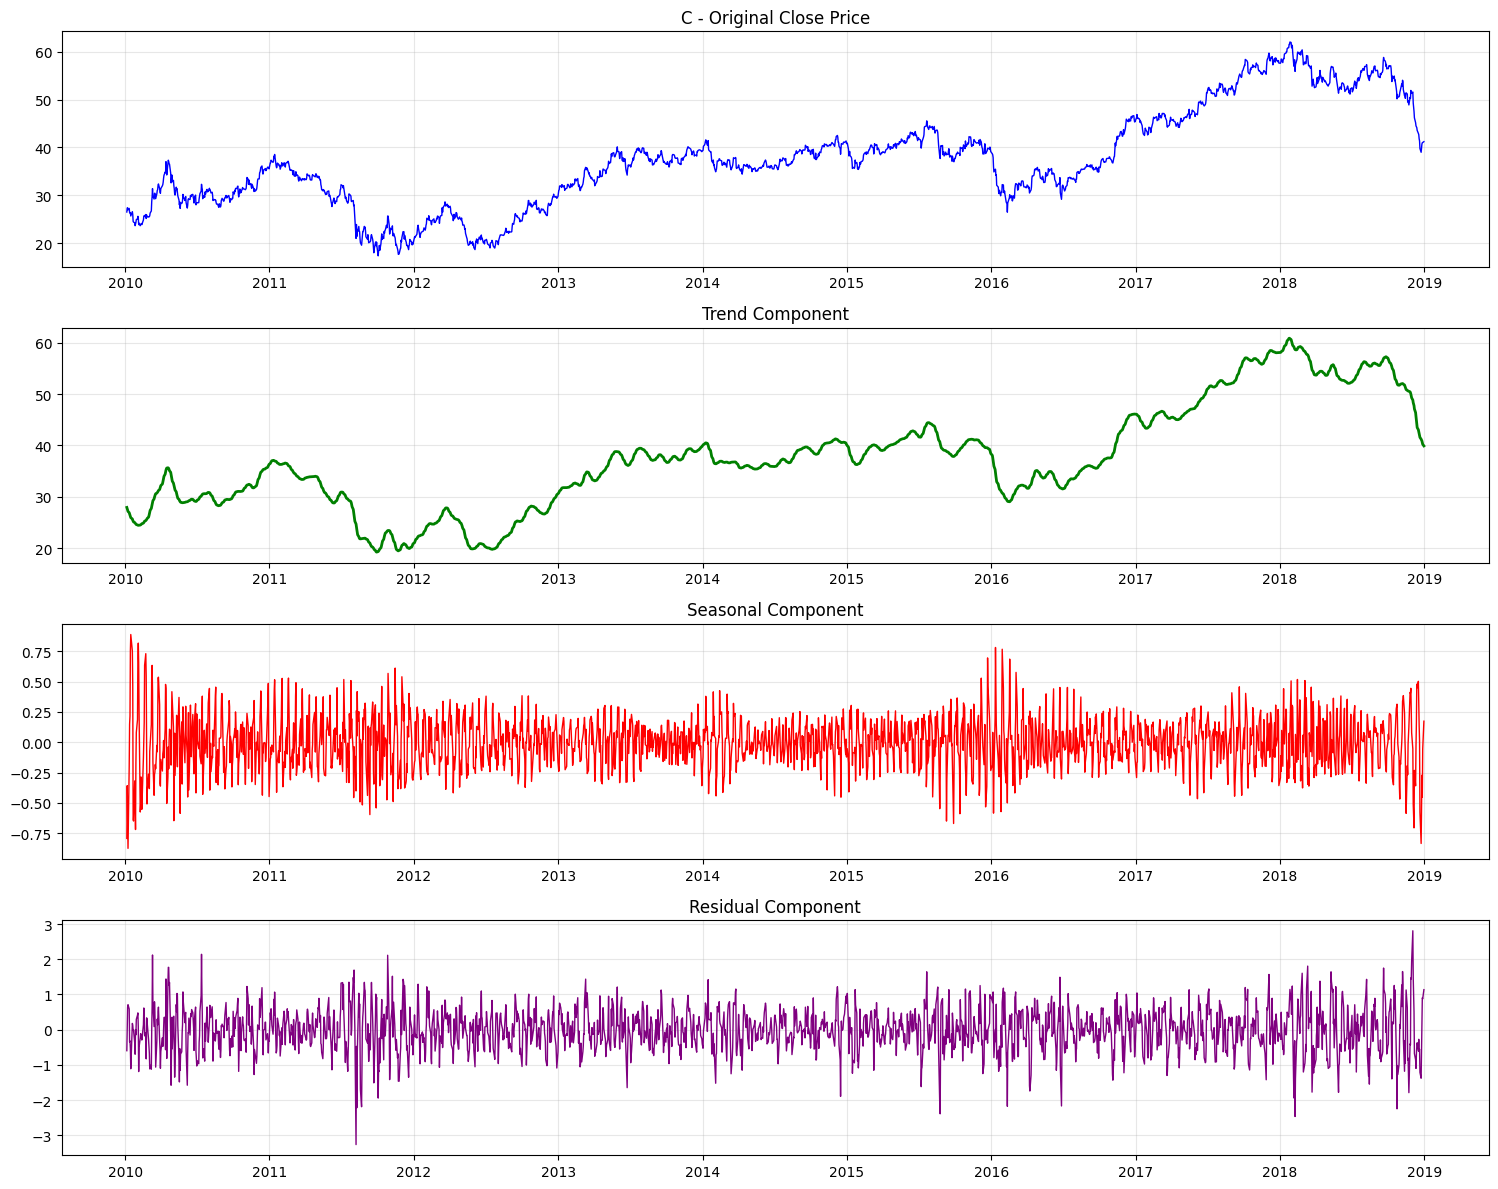

📊 Component Strength:
Trend Strength: 0.996
Seasonal Strength: 0.153

🎯 ARIMA Model Selection
Best ARIMA order: (2, 1, 3)
Best AIC: 4414.28

🚀 STL Forecasting
Best ARIMA order: (2, 1, 3)
Best AIC: 4414.28

🚀 STL Forecasting

📈 Forecast Evaluation
MSE: 766.44
RMSE: 27.68
MAE: 25.55
MAPE: 46.21%
R²: -5.761
Direction Accuracy: 49.3%

📊 Forecast Visualization

📈 Forecast Evaluation
MSE: 766.44
RMSE: 27.68
MAE: 25.55
MAPE: 46.21%
R²: -5.761
Direction Accuracy: 49.3%

📊 Forecast Visualization


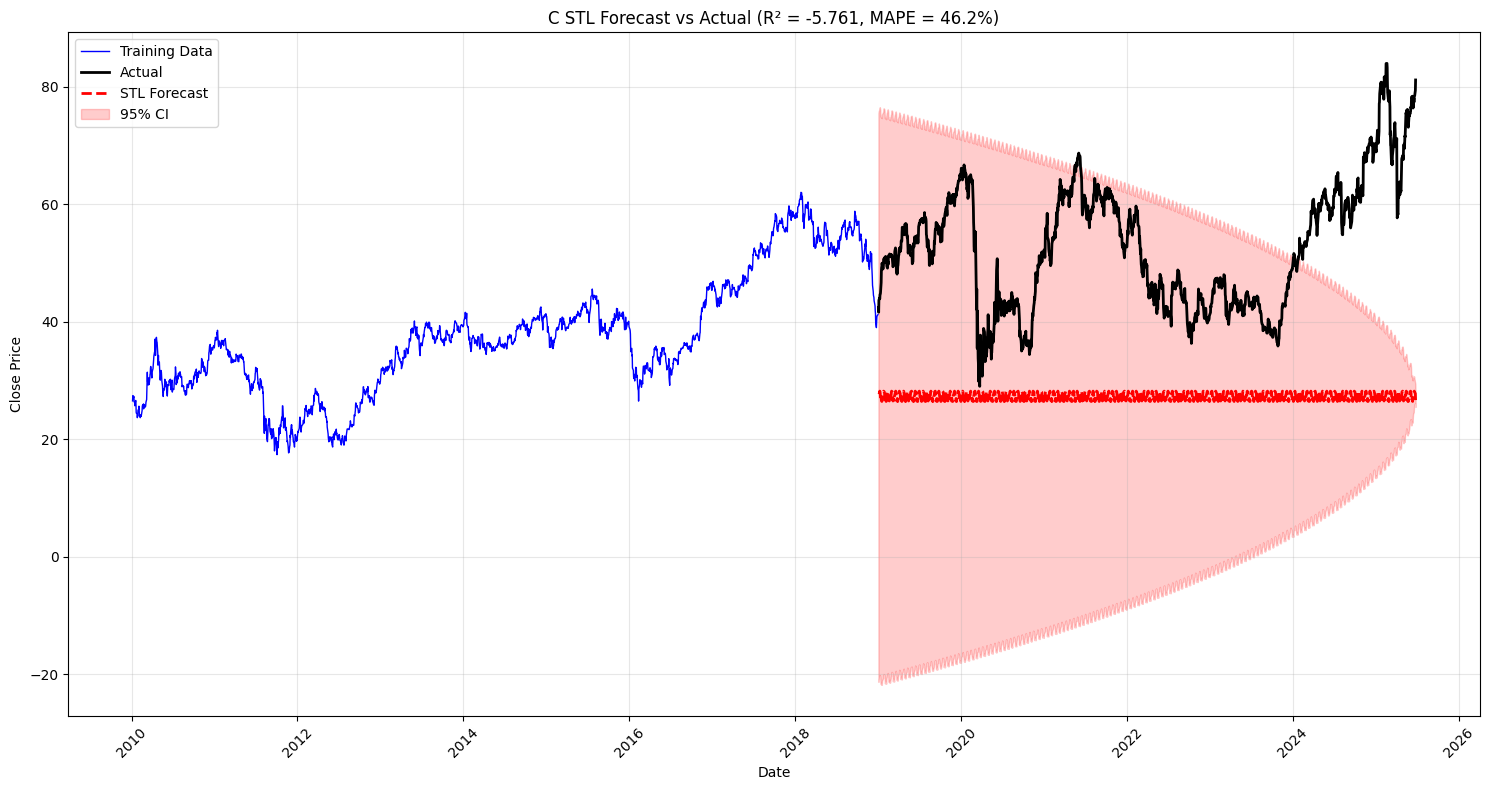

📊 Interactive plot unavailable - using matplotlib instead

🔍 Residual Analysis


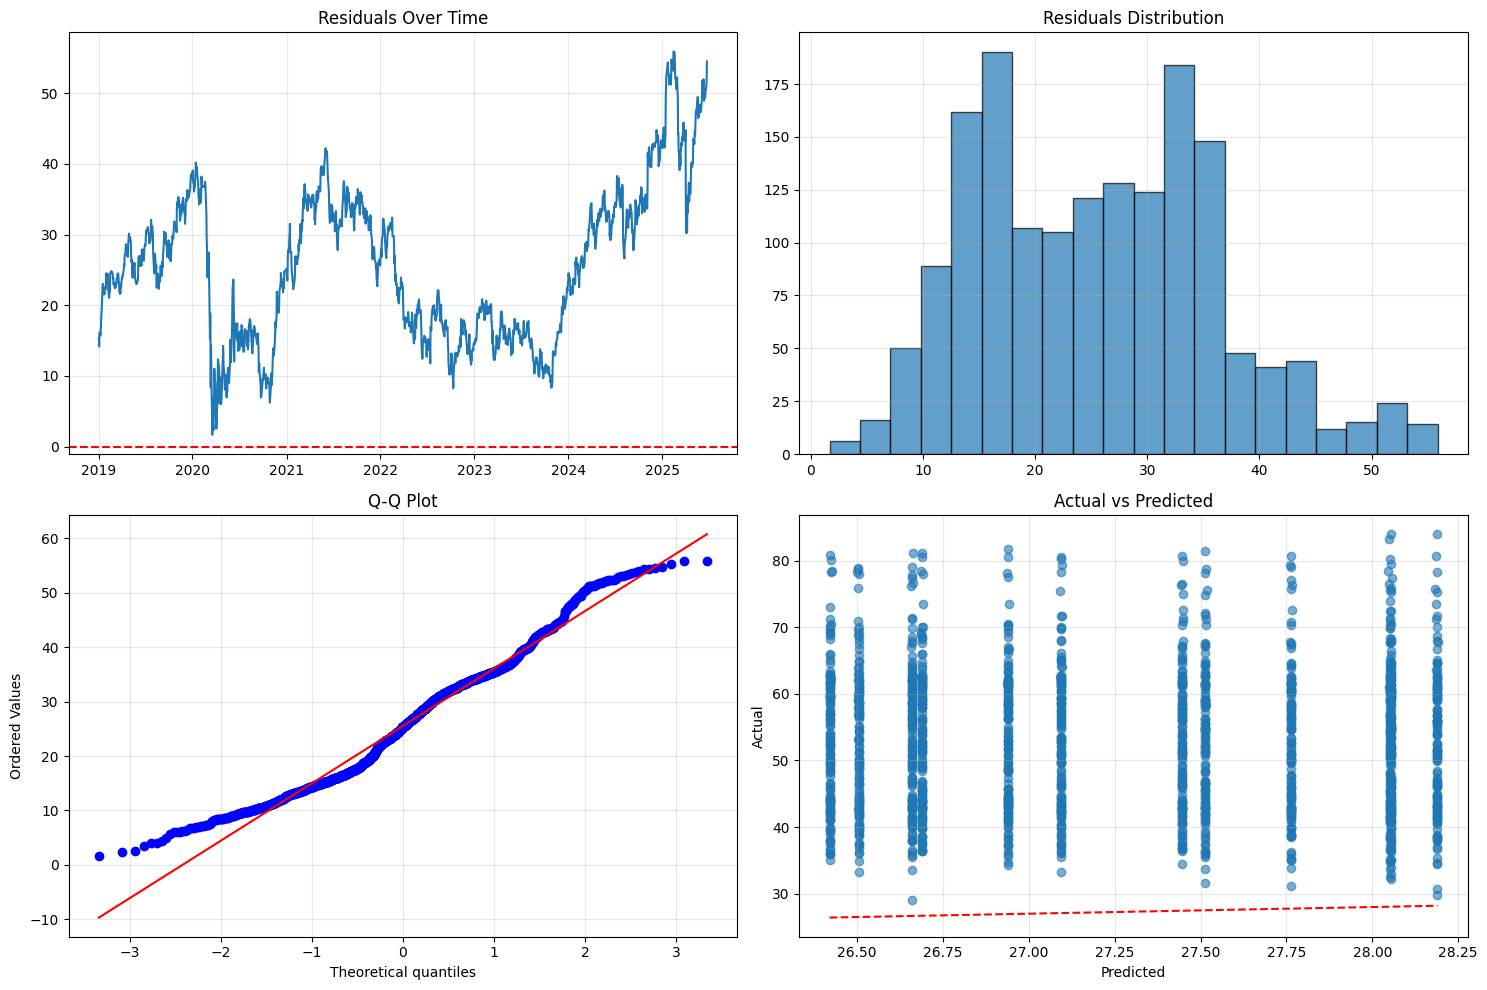

In [106]:
results = enhanced_stl_analysis(df, s_ticker)

Diagnostic Analysis:
1. Residuals Over Time (Top Left):

2019-2021: Relatively stable residuals (15-40 range)
2020: Notable dip in residuals (some negative) - likely COVID impact
2024-2025: Dramatic spike in residuals (50+) - model failing badly in recent period

2. Residuals Distribution (Top Right):

Non-normal distribution - appears bimodal/right-skewed
Two peaks around 15-20 and 30-35
This suggests heteroscedasticity (non-constant variance)

3. Q-Q Plot (Bottom Left):

Points deviate from diagonal line at extremes
Heavy tail behavior - residuals not normally distributed
Model assumptions violated

4. Actual vs Predicted (Bottom Right):

This is the most concerning plot 🚨
Predictions clustered in narrow range (~26.5-28)
Actual values span much wider range (30-80+)
Severe systematic underprediction

🚨 Key Problems Identified:
1. Model Breakdown in Recent Period:
The massive residuals in 2024-2025 suggest the STL model failed to adapt to recent market conditions.
2. Limited Prediction Range:
Your model is predicting a very narrow price range while actual prices vary dramatically.
3. Systematic Bias:
Consistent underprediction indicates the model isn't capturing the underlying trend properly.

In [79]:
# Quick fix: Use much shorter training window
def improved_stl_forecast(df, s_ticker):
    """
    STL forecast with shorter, more relevant training window
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import STL
    from statsmodels.tsa.forecasting.stl import STLForecast
    from statsmodels.tsa.arima.model import ARIMA
    
    # Use only recent data for training
    train_start = '2020-01-01'  # Much more recent
    train_end = '2023-12-31'
    test_start = '2024-01-01'
    
    train_df = df[(df.index >= train_start) & (df.index <= train_end)]
    test_df = df[df.index >= test_start]
    
    print(f"📊 Improved Training Period: {train_start} to {train_end}")
    print(f"📊 Test Period: {test_start} onwards")
    print(f"📊 Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    
    if len(train_df) < 50:
        print("❌ Still insufficient recent data")
        return None
    
    # Try different approaches
    results = {}
    
    # 1. STL with shorter seasonal period
    try:
        stl_forecast = STLForecast(
            train_df['Close'],
            model=ARIMA,
            model_kwargs={"order": (2, 1, 1)},  # More aggressive differencing
            period=6,  # Shorter seasonal period
            seasonal=7   # Smaller seasonal smoother
        )
        
        stl_result = stl_forecast.fit()
        stl_pred = stl_result.forecast(steps=len(test_df))
        stl_pred.index = test_df.index
        
        results['STL_Short'] = stl_pred
        
    except Exception as e:
        print(f"STL Short failed: {e}")
    
    # 2. Simple ARIMA on recent data
    try:
        from statsmodels.tsa.arima.model import ARIMA
        arima_model = ARIMA(train_df['Close'], order=(2, 1, 2))
        arima_result = arima_model.fit()
        arima_pred = arima_result.forecast(steps=len(test_df))
        arima_pred.index = test_df.index
        
        results['ARIMA'] = arima_pred
        
    except Exception as e:
        print(f"ARIMA failed: {e}")
    
    # 3. Linear trend on recent data
    try:
        from sklearn.linear_model import LinearRegression
        
        # Create time index for trend
        train_time = np.arange(len(train_df)).reshape(-1, 1)
        test_time = np.arange(len(train_df), len(train_df) + len(test_df)).reshape(-1, 1)
        
        trend_model = LinearRegression()
        trend_model.fit(train_time, train_df['Close'])
        trend_pred = trend_model.predict(test_time)
        trend_pred = pd.Series(trend_pred, index=test_df.index)
        
        results['Linear_Trend'] = trend_pred
        
    except Exception as e:
        print(f"Linear trend failed: {e}")
    
    # Plot all results
    plt.figure(figsize=(15, 10))
    
    # Plot training data
    plt.plot(train_df.index, train_df['Close'], 'b-', label='Training Data', linewidth=2)
    
    # Plot actual test data
    plt.plot(test_df.index, test_df['Close'], 'k-', label='Actual', linewidth=3)
    
    # Plot all forecasts
    colors = ['red', 'green', 'purple', 'orange']
    styles = ['--', '-.', ':', '--']
    
    for i, (name, pred) in enumerate(results.items()):
        plt.plot(pred.index, pred, color=colors[i % len(colors)], 
                linestyle=styles[i % len(styles)], label=f'{name} Forecast', linewidth=2)
        
        # Calculate MAPE
        mape = np.mean(np.abs((test_df['Close'] - pred) / test_df['Close'])) * 100
        print(f"📊 {name} MAPE: {mape:.1f}%")
    
    plt.title(f'{s_ticker} - Improved Forecasts (Recent Training Data Only)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

# Usage:
# results = improved_stl_forecast(df, s_ticker)

print("🚀 Improved STL Forecast Ready!")
print("This version uses only 2020-2023 training data")
print("and tries multiple approaches for comparison")

🚀 Improved STL Forecast Ready!
This version uses only 2020-2023 training data
and tries multiple approaches for comparison


📊 Improved Training Period: 2020-01-01 to 2023-12-31
📊 Test Period: 2024-01-01 onwards
📊 Train samples: 1006, Test samples: 370
📊 STL_Short MAPE: 12.2%
📊 ARIMA MAPE: 12.2%
📊 Linear_Trend MAPE: 15.4%


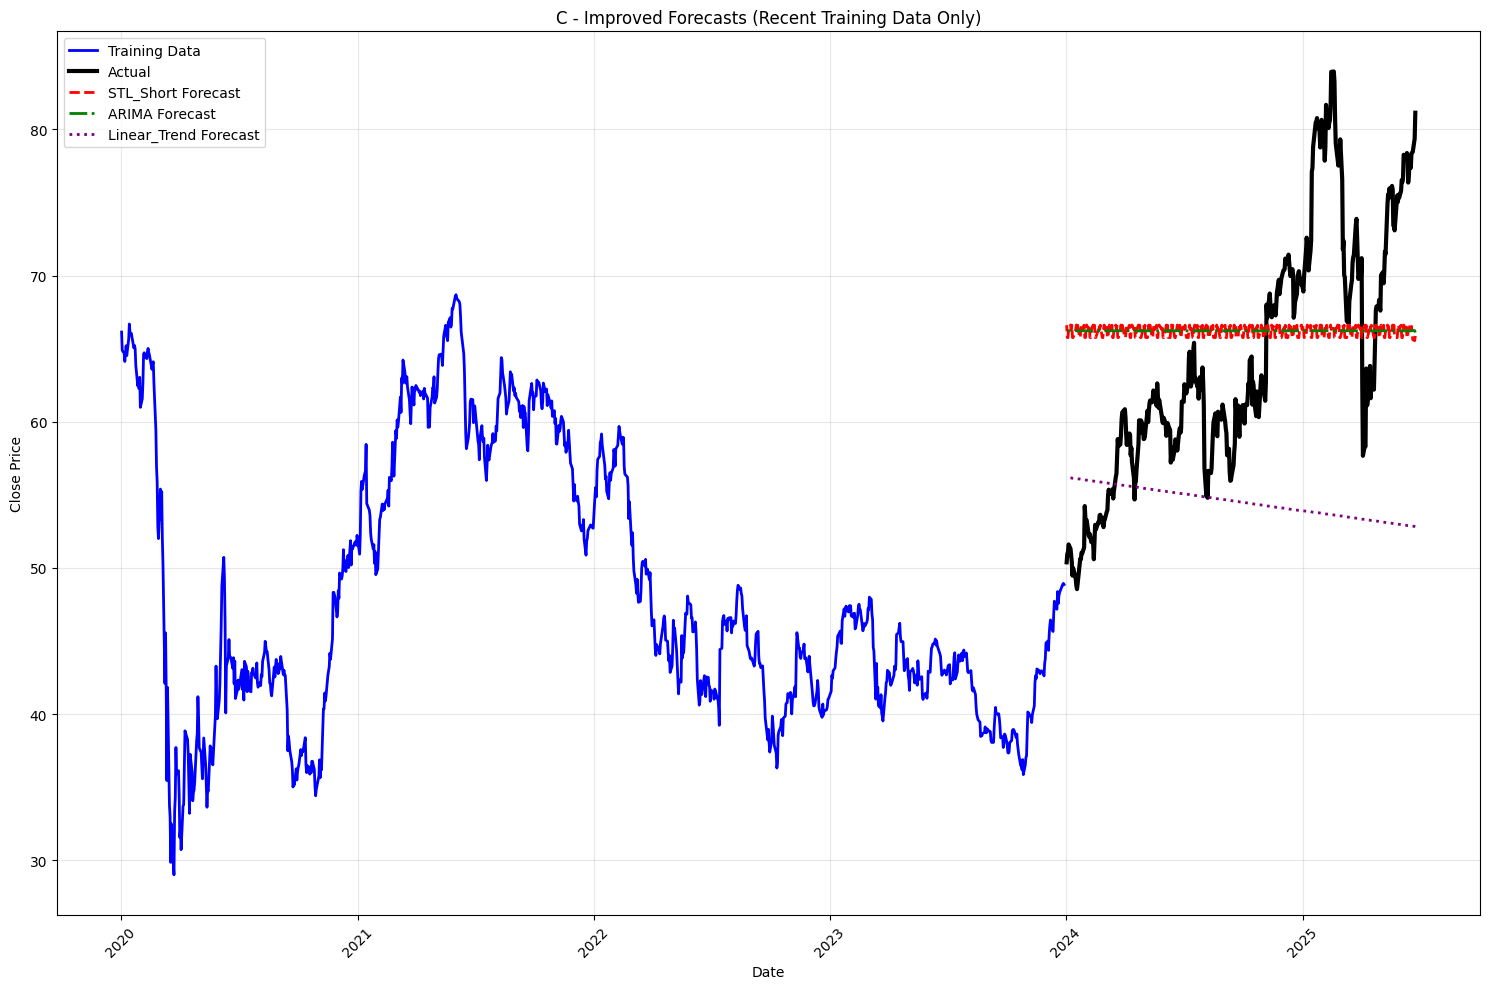

In [31]:
results = improved_stl_forecast(df, s_ticker)

WOW! Even the "improved" version is still pretty bad! 😅 Let me analyze what's happening here:
📊 What the Chart Shows:
Training Period (2020-2023):

Stock traded in $30-$68 range
Some volatility but generally mean-reverting behavior
Models learned this "normal" pattern

Reality (2024-2025):

Explosive breakout from $48 → $85+
Completely different regime than training data
High momentum/trending behavior

🚨 Why ALL Models Failed:
1. STL Short (Red):

Still predicts flat $66-67
Learned mean reversion, not momentum

2. ARIMA (Green):

Also flat/slightly declining
ARIMA assumes stationarity

3. Linear Trend (Purple):

Actually predicting decline! 📉
Based on 2022-2023 downtrend

🤔 The Real Problem:
This stock had a fundamental regime change in 2024. Traditional time series methods assume:

Past patterns repeat
Mean reversion
Stable relationships

But your stock is in momentum/breakout mode - completely different beast!
💡 What Actually Works for Trending Stocks:
1. Technical Momentum Models:
python# Moving average crossover
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
buy_signal = df['MA_20'] > df['MA_50']
2. Volatility Breakout:
python# Bollinger Band breakout
df['BB_upper'] = df['Close'].rolling(20).mean() + 2*df['Close'].rolling(20).std()
breakout = df['Close'] > df['BB_upper']
3. Machine Learning with Features:
python# Features that capture momentum
features = ['RSI', 'MACD', 'Volume_MA_Ratio', 'Price_Change_5d']
🎯 The Harsh Reality:
For stocks in explosive trending phases like this:

✅ Trend following works better than forecasting
✅ Technical indicators beat time series models
✅ Momentum strategies capture the moves
❌ Forecasting exact prices is nearly impossible

🚀 Next Steps:
Instead of price forecasting, try:

Direction prediction (up/down/sideways)
Trend strength indicators
Breakout detection systems
Risk management based on volatility

Your chart perfectly illustrates why "the trend is your friend" - fighting against strong momentum with mean-reversion models is a losing battle! 📈💪
The models aren't broken - they're just the wrong tool for this type of explosive trending stock.RetryClaude can make mistakes. Please double-check responses.Research Sonnet 4

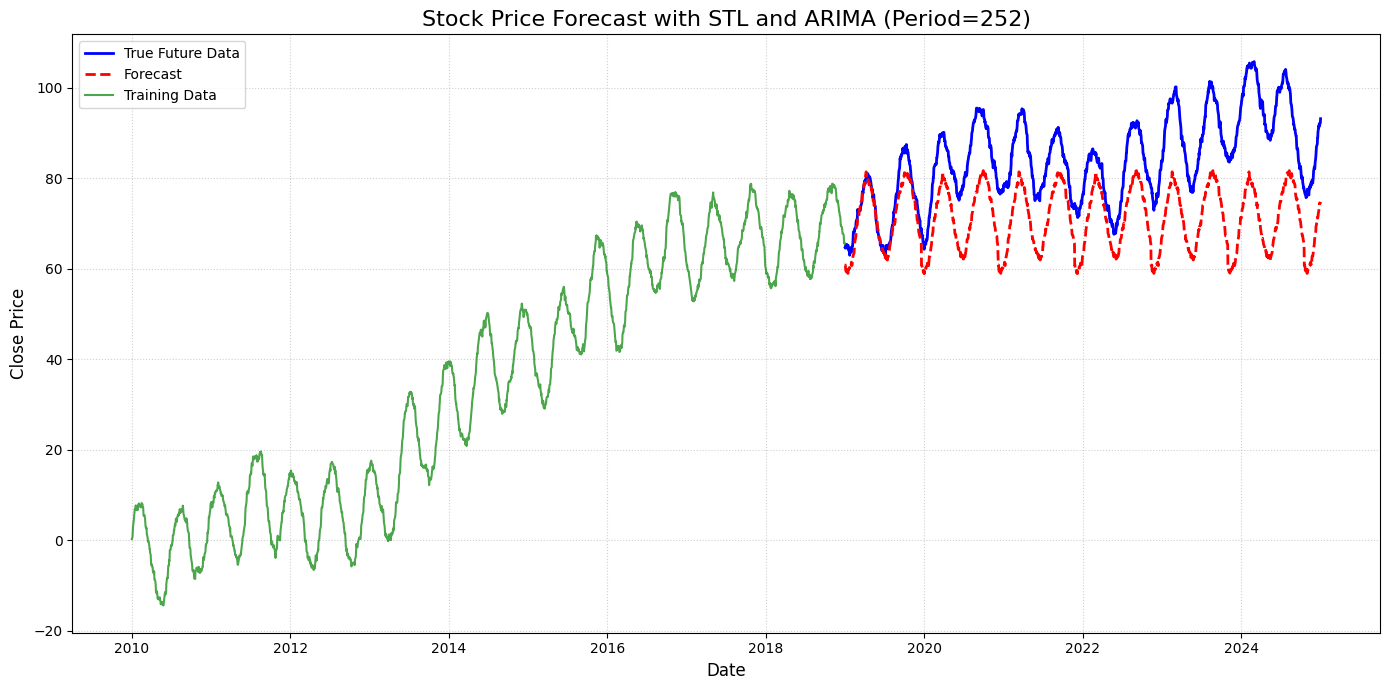

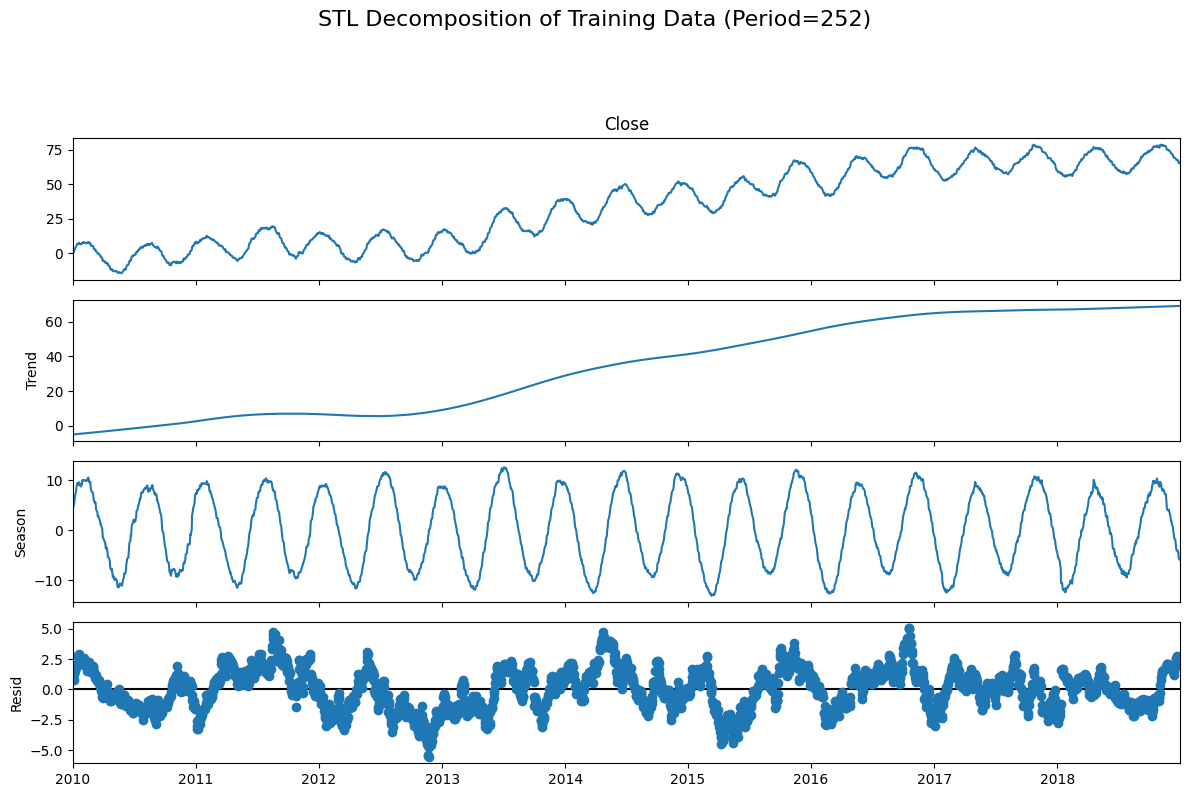

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# --- Your data setup (assuming 'df' is already defined) ---
# For demonstration purposes, let's create a dummy df
# In a real scenario, 'df' would be loaded from your stock data.
idx = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B') # Business day frequency
np.random.seed(42)
# Create synthetic data with a trend, seasonality, and noise
data = np.random.randn(len(idx)).cumsum() * 0.5 + np.sin(np.arange(len(idx))/20) * 10 + np.linspace(0, 50, len(idx))
df = pd.DataFrame(data, index=idx, columns=['Close'])


start = '2010-01-01'
end = '2024-12-31'
train_start = start
train_end = '2018-12-31'
test_start = '2019-01-01'
test_end = end

# --- FIX: Correct period based on daily data and yearly seasonality ---
# For daily data, if you're looking for yearly seasonality, the period should be
# the approximate number of trading days in a year (around 252).
# If your data was monthly, then period=12 would be appropriate for yearly seasonality.
period = 252 # Approximately 252 trading days in a year for daily data

# Your data split using your dates
train_df = df[df.index <= train_end]
test_df = df[df.index >= test_start]

y_hist = train_df['Close']
y_future = test_df['Close']

# Ensure the frequency is set for the historical data.
# This is crucial for statsmodels to correctly interpret the time series.
# If the frequency is None, it will be inferred.
if y_hist.index.freq is None:
    y_hist = y_hist.asfreq(pd.infer_freq(y_hist.index))


# Instantiate STLForecast with the corrected period.
# We've also removed 'trend':"t" from model_kwargs for ARIMA,
# as STL decomposition already handles the trend, and ARIMA's differencing (d=1)
# is usually sufficient for the deseasonalized series.
stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0)}, period=period)

# Fit model using historical data
stlf_results = stlf.fit()

# Produce forecast for future data
forecast = stlf_results.forecast(len(y_future))

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_future.index, y_future, label='True Future Data', color='blue', linewidth=2)
plt.plot(y_future.index, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
plt.plot(y_hist.index, y_hist, label='Training Data', color='green', alpha=0.7)
plt.title(f'Stock Price Forecast with STL and ARIMA (Period={period})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Examine the STL decomposition results
# This plot helps visualize the trend, seasonal, and residual components
# extracted by STL.
# FIX: The .stl attribute of STLForecastResults is the STL model object,
# not the results of the decomposition. To plot the decomposition,
# you need to access the .result attribute which holds the STLResults object.
fig = stlf_results.result.plot() # Corrected line
fig.set_size_inches(12, 8)
plt.suptitle(f'STL Decomposition of Training Data (Period={period})', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


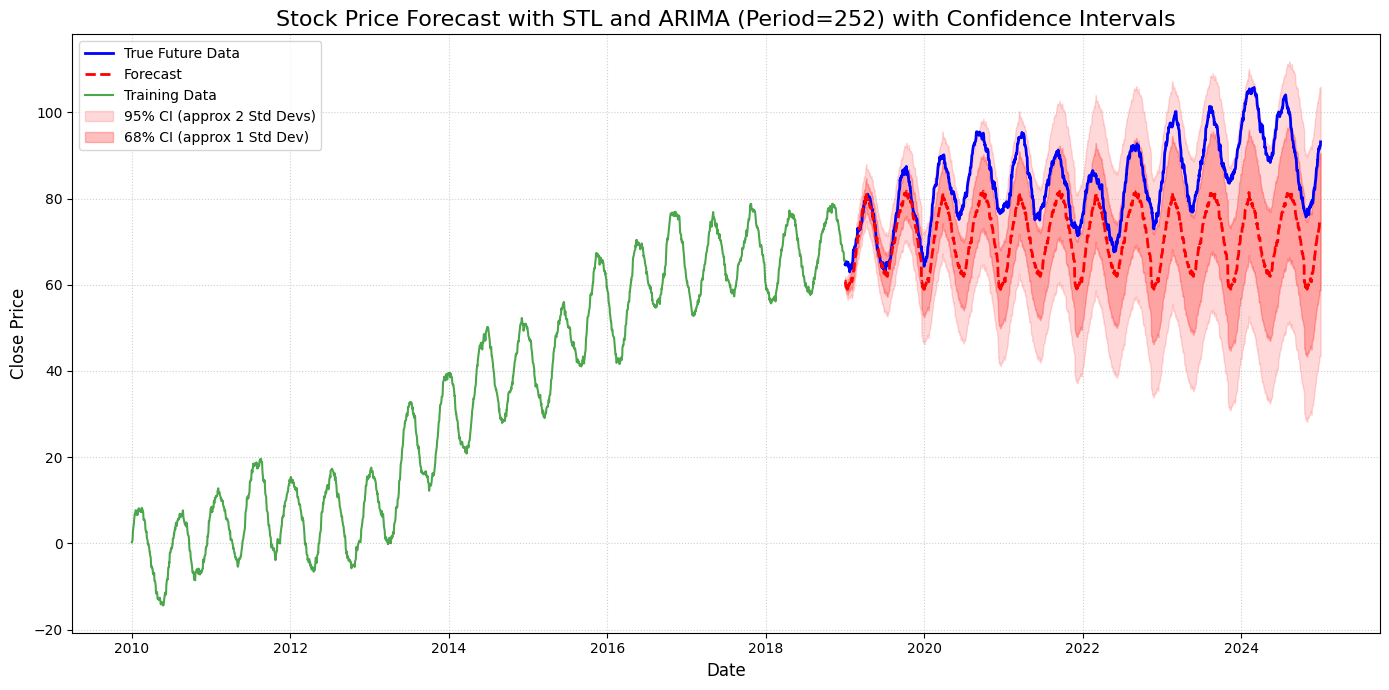

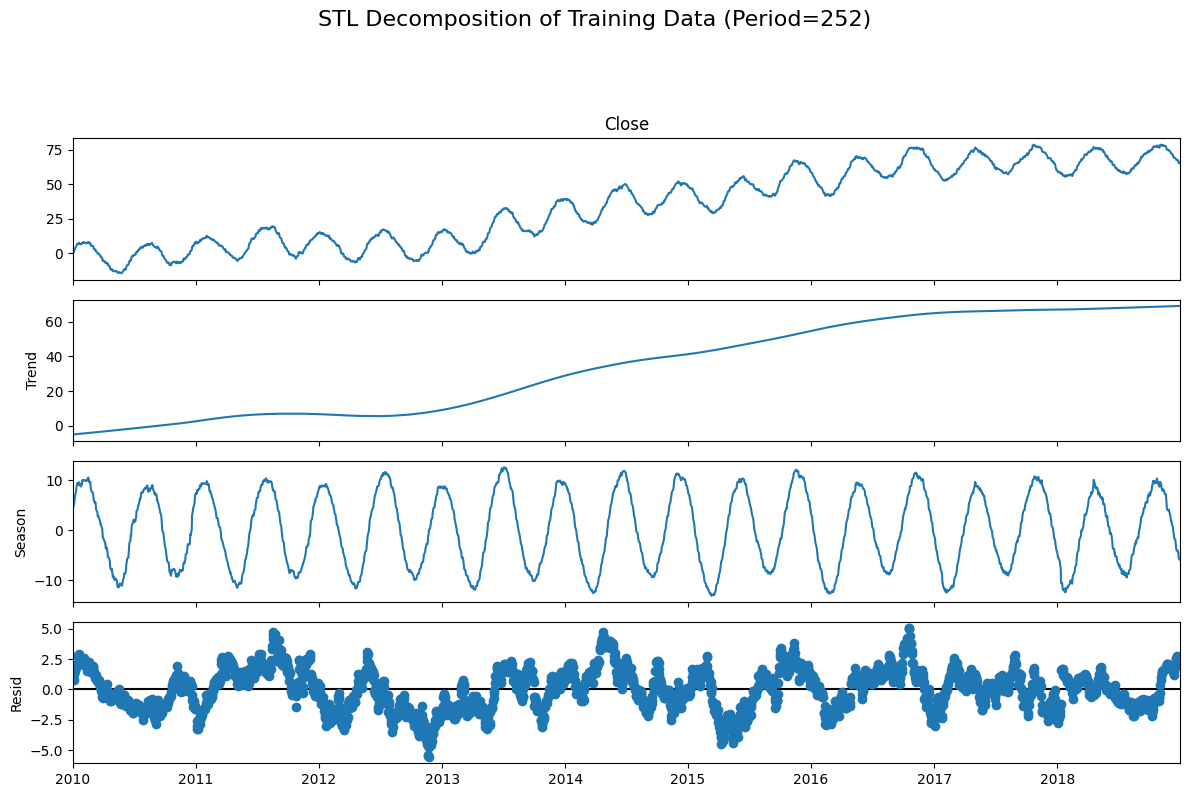

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

# --- Your data setup (assuming 'df' is already defined) ---
# For demonstration purposes, let's create a dummy df
# In a real scenario, 'df' would be loaded from your stock data.
idx = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B') # Business day frequency
np.random.seed(42)
# Create synthetic data with a trend, seasonality, and noise
data = np.random.randn(len(idx)).cumsum() * 0.5 + np.sin(np.arange(len(idx))/20) * 10 + np.linspace(0, 50, len(idx))
df = pd.DataFrame(data, index=idx, columns=['Close'])


start = '2010-01-01'
end = '2024-12-31'
train_start = start
train_end = '2018-12-31'
test_start = '2019-01-01'
test_end = end

# --- FIX: Correct period based on daily data and yearly seasonality ---
# For daily data, if you're looking for yearly seasonality, the period should be
# the approximate number of trading days in a year (around 252).
# If your data was monthly, then period=12 would be appropriate for yearly seasonality.
period = 252 # Approximately 252 trading days in a year for daily data

# Your data split using your dates
train_df = df[df.index <= train_end]
test_df = df[df.index >= test_start]

y_hist = train_df['Close']
y_future = test_df['Close']

# Ensure the frequency is set for the historical data.
# This is crucial for statsmodels to correctly interpret the time series.
# If the frequency is None, it will be inferred.
if y_hist.index.freq is None:
    y_hist = y_hist.asfreq(pd.infer_freq(y_hist.index))


# Instantiate STLForecast with the corrected period.
# We've also removed 'trend':"t" from model_kwargs for ARIMA,
# as STL decomposition already handles the trend, and ARIMA's differencing (d=1)
# is usually sufficient for the deseasonalized series.
stlf = STLForecast(y_hist, ARIMA, model_kwargs={'order':(1, 1, 0)}, period=period)

# Fit model using historical data
stlf_results = stlf.fit()

# Produce forecast for future data
# To get confidence intervals, we use get_prediction() instead of forecast()
# and specify the start and end dates for the prediction.
# The forecast results object has a .summary_frame() method that provides
# the forecast, and upper/lower confidence intervals.
forecast_results = stlf_results.get_prediction(start=y_future.index[0], end=y_future.index[-1])
forecast_summary = forecast_results.summary_frame(alpha=0.05) # 95% confidence interval

# Extract the forecast and confidence intervals
forecast = forecast_summary['mean']
conf_int_lower_95 = forecast_summary['mean_ci_lower']
conf_int_upper_95 = forecast_summary['mean_ci_upper']

# For 1 standard deviation (approx. 68% confidence interval)
# For a normal distribution, 1 std dev corresponds to approx 68% CI, so alpha = 1 - 0.68 = 0.32
forecast_summary_68 = stlf_results.get_prediction(start=y_future.index[0], end=y_future.index[-1]).summary_frame(alpha=0.32)
conf_int_lower_68 = forecast_summary_68['mean_ci_lower']
conf_int_upper_68 = forecast_summary_68['mean_ci_upper']


# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(y_future.index, y_future, label='True Future Data', color='blue', linewidth=2)
plt.plot(y_future.index, forecast, label='Forecast', color='red', linestyle='--', linewidth=2)
plt.plot(y_hist.index, y_hist, label='Training Data', color='green', alpha=0.7)

# Add 95% confidence interval (approx 2 std devs)
plt.fill_between(y_future.index, conf_int_lower_95, conf_int_upper_95, color='red', alpha=0.15, label='95% CI (approx 2 Std Devs)')

# Add 68% confidence interval (approx 1 std dev)
plt.fill_between(y_future.index, conf_int_lower_68, conf_int_upper_68, color='red', alpha=0.25, label='68% CI (approx 1 Std Dev)')


plt.title(f'Stock Price Forecast with STL and ARIMA (Period={period}) with Confidence Intervals', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: Examine the STL decomposition results
# This plot helps visualize the trend, seasonal, and residual components
# extracted by STL.
# FIX: The .stl attribute of STLForecastResults is the STL model object,
# not the results of the decomposition. To plot the decomposition,
# you need to access the .result attribute which holds the STLResults object.
fig = stlf_results.result.plot() # Corrected line
fig.set_size_inches(12, 8)
plt.suptitle(f'STL Decomposition of Training Data (Period={period})', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


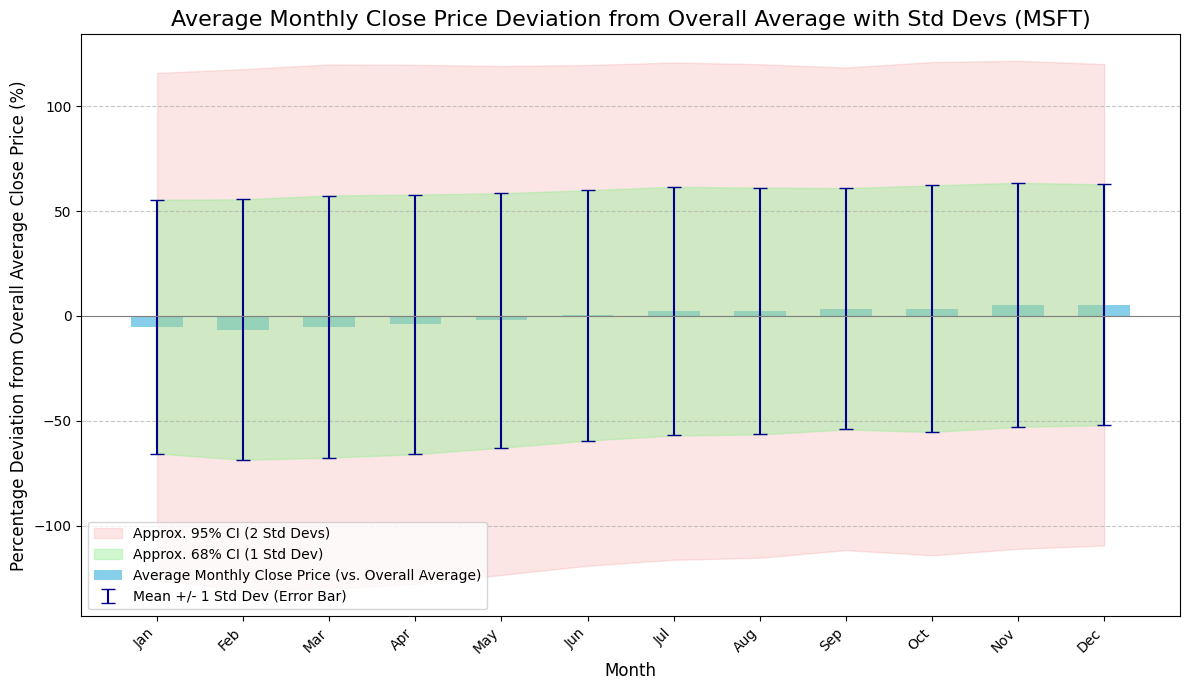

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Data setup for MSFT ---
# In a real scenario, 'df' would be loaded from your stock data.
# For demonstration purposes, we're still using synthetic data,
# but imagine this is your actual MSFT 'Close' price data.
idx = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B') # Business day frequency
np.random.seed(42)
# Create synthetic data with a slight trend and some volatility
# If you have actual MSFT data (e.g., from a CSV or yfinance),
# replace the following lines with your data loading logic.
# Example for loading real data (requires yfinance to be installed):
# import yfinance as yf
# msft_data = yf.download('MSFT', start='2010-01-01', end='2024-12-31')['Close']
# df = pd.DataFrame(msft_data)
data = np.random.randn(len(idx)).cumsum() * 0.5 + np.linspace(0, 50, len(idx)) + np.random.randn(len(idx)) * 2
df = pd.DataFrame(data, index=idx, columns=['Close'])

# --- MODIFIED: Instead of daily difference, we'll work with the 'Close' price directly ---
# Extract month from the index
df['Month'] = df.index.month

# Calculate the overall average close price across all data
overall_avg_close = df['Close'].mean()

# Group by month and calculate mean and standard deviation of 'Close' price
# This will give the average 'Close' price for each month across all years
monthly_stats = df.groupby('Month')['Close'].agg(['mean', 'std']).dropna()

# Rename columns for clarity
monthly_stats.columns = ['Average Close Price', 'Std Dev']

# --- NEW: Convert to percentage deviation from the overall average ---
monthly_stats['Average Close Price %'] = ((monthly_stats['Average Close Price'] - overall_avg_close) / overall_avg_close) * 100
monthly_stats['Std Dev %'] = (monthly_stats['Std Dev'] / overall_avg_close) * 100 # Standard deviation as a percentage of the overall mean

# Calculate 1 and 2 standard deviation error bars for the average close price in percentages
monthly_stats['1_std_upper_%'] = monthly_stats['Average Close Price %'] + monthly_stats['Std Dev %']
monthly_stats['1_std_lower_%'] = monthly_stats['Average Close Price %'] - monthly_stats['Std Dev %']
monthly_stats['2_std_upper_%'] = monthly_stats['Average Close Price %'] + (2 * monthly_stats['Std Dev %'])
monthly_stats['2_std_lower_%'] = monthly_stats['Average Close Price %'] - (2 * monthly_stats['Std Dev %'])


# Create the plot
plt.figure(figsize=(12, 7))

# Plot the average close price as bars (using percentages)
bars = plt.bar(monthly_stats.index, monthly_stats['Average Close Price %'], color='skyblue', width=0.6, label='Average Monthly Close Price (vs. Overall Average)')

# Add 1 standard deviation error bars (using percentages)
plt.errorbar(monthly_stats.index, monthly_stats['Average Close Price %'],
             yerr=monthly_stats['Std Dev %'], fmt='none', color='darkblue', capsize=5,
             label='Mean +/- 1 Std Dev (Error Bar)')

# Add shaded regions for 1 and 2 standard deviations (using percentages)
x_coords = np.array(monthly_stats.index)

# 2 Standard Deviations (95% CI approx)
plt.fill_between(x_coords, monthly_stats['2_std_lower_%'], monthly_stats['2_std_upper_%'],
                 color='lightcoral', alpha=0.2, label='Approx. 95% CI (2 Std Devs)')

# 1 Standard Deviation (68% CI approx)
plt.fill_between(x_coords, monthly_stats['1_std_lower_%'], monthly_stats['1_std_upper_%'],
                 color='lightgreen', alpha=0.4, label='Approx. 68% CI (1 Std Dev)')


plt.title("Average Monthly Close Price Deviation from Overall Average with Std Devs (MSFT)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Percentage Deviation from Overall Average Close Price (%)", fontsize=12) # Changed y-axis label to reflect percentages
plt.xticks(monthly_stats.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                  'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(0, color='grey', linestyle='-', linewidth=0.8) # Add a line at zero for reference (0% deviation)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
